# Sample Project Coronavirus

The goal of this project is to explore a dataset of coronavirus patients to train a model which predicts whether a patient will die or recover from Coronavirus. 

## About the data

The dataset confirmed-positive-on data comes from https://howsmyflattening.ca/#/data/. 

The site is set up by a group of physicians, medical students, computational health researchers, designers and epidemiologists who aim to rapidly filter and present emergent COVID-19 data to help Ontario #FlattenTheCurve. They intend to connect experts and present data in an easy to digest, actionable way to help Ontario's public leaders and individuals act decisively as evidence grows and time ticks by.

### Confirmed positive cases of COVID19 in Ontario

The dataset includes compiled daily reported data from public health units on confirmed positive cases of COVID-19 in Ontario. It includes data on patients from 1st January 2020 to 28th June 2020 and is updated daily. Currently, the dataset inludes data from 37,947 patients. Case data is as initially reported.

The following are the features which we will use for predicting the outcome variable (recovered or diseased).

1. accurate_episode_date - date of diagnosis
2. age_group - categorized to <20, 30s, 40s, 50s, 60s, 70s, 80s or 90s
3. client_gender - female, male, unkown, other,or transgender
4. outbreak_related - Yes or no entry
5. reporting_phu_latitude - Latitude of the reporting public health unit
6. reporting_phu_longitude - longitude of the reporting public health unit




### Preparing the tools

In [2]:
# Exploratory Data Analysis and plotting libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Cleaning with Scikit Learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Models from Skikit Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

### Load Data

In [3]:
df = pd.read_csv("confirmed_positive_on.csv", sep =";")
df.shape

(37947, 18)

## Explorative Data Anlysis

In [188]:
df.head()

,id,row_id,accurate_episode_date,age_group,client_gender,case_acquisitionInfo,outcome1,outbreak_related,reporting_phu,reporting_phu_address,reporting_phu_city,reporting_phu_postal_code,reporting_phu_website,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,specimen_reported_date,test_reported_date
0,4066,4066,2020-03-28,20s,FEMALE,Travel,Resolved,NaN,Windsor-Essex County Health Unit,1005 Ouellette Avenue,Windsor,N9A 4J8,www.wechu.org,42.308796,-83.033670,2020-04-03,2020-03-30,2020-04-03
1,1091,1091,2020-03-13,30s,MALE,Travel,Resolved,NaN,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912,2020-03-26,2020-03-17,2020-03-26
2,34119,33188,2020-04-12,20s,FEMALE,No Epi-link,Resolved,NaN,Middlesex-London Health Unit,50 King Street,London,N6A 5L7,www.healthunit.com,42.981468,-81.254016,2020-05-20,2020-05-17,2020-05-20
3,9095,9095,2020-04-12,30s,FEMALE,CC,Resolved,NaN,"Region of Waterloo, Public Health",99 Regina Street South,Waterloo,N2J 4V3,www.regionofwaterloo.ca,43.462876,-80.520913,2020-04-15,2020-04-14,2020-04-15
4,1713,1713,2020-03-23,30s,MALE,CC,Resolved,NaN,Eastern Ontario Health Unit,1000 Pitt Street,Cornwall,K6J 5T1,www.eohu.ca,45.029152,-74.736298,2020-04-01,2020-03-24,2020-04-01


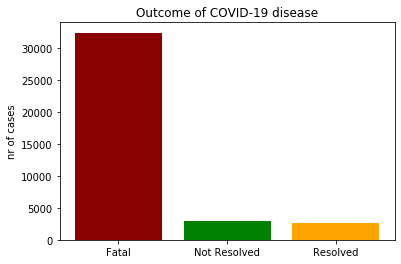

In [189]:
fig, ax = plt.subplots()
ax.bar(x = list(set(df["outcome1"])), height = df["outcome1"].value_counts(), color=['darkred', 'g', 'orange'])
ax.set_ylabel("nr of cases")
ax.set_title("Outcome of COVID-19 disease")

plt.show()



In [190]:
df["outcome1"].value_counts(normalize = True)

Resolved        0.854033
Fatal           0.075895
Not Resolved    0.070071
Name: outcome1, dtype: float64

The dataset is highly unbalanced with approximately 85 % recoveries, 8 % fatal outcomes and 7 % not yet resolved cases. For now, we shall exclude unresolved cases from our analysis. 

In [3]:
df.drop(df[df["outcome1"] == "Not Resolved"].index, inplace = True)

In [4]:
df["outcome1"].value_counts(normalize = True)

Resolved        0.854033
Fatal           0.075895
Not Resolved    0.070071
Name: outcome1, dtype: float64

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35288 entries, 0 to 37946
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         35288 non-null  int64  
 1   row_id                     35288 non-null  int64  
 2   accurate_episode_date      35286 non-null  object 
 3   age_group                  35288 non-null  object 
 4   client_gender              35288 non-null  object 
 5   case_acquisitionInfo       35288 non-null  object 
 6   outcome1                   35288 non-null  object 
 7   outbreak_related           14676 non-null  object 
 8   reporting_phu              35288 non-null  object 
 9   reporting_phu_address      35288 non-null  object 
 10  reporting_phu_city         35288 non-null  object 
 11  reporting_phu_postal_code  35288 non-null  object 
 12  reporting_phu_website      35288 non-null  object 
 13  reporting_phu_latitude     35288 non-null  flo

### Cleaning features

In [194]:
df.isna().sum()

id                               0
row_id                           0
accurate_episode_date            2
age_group                        0
client_gender                    0
case_acquisitionInfo             0
outcome1                         0
outbreak_related             20612
reporting_phu                    0
reporting_phu_address            0
reporting_phu_city               0
reporting_phu_postal_code        0
reporting_phu_website            0
reporting_phu_latitude           0
reporting_phu_longitude          0
case_reported_date               0
specimen_reported_date         329
test_reported_date             447
dtype: int64

### COVID 19 outcome according to Gender

In [40]:
df.client_gender.value_counts()

FEMALE         19006
MALE           16005
UNKNOWN          262
OTHER              8
TRANSGENDER        7
Name: client_gender, dtype: int64

In [45]:
pd.crosstab(df.outcome1, df.client_gender)

client_gender,FEMALE,MALE,OTHER,TRANSGENDER,UNKNOWN
outcome1,,,,,
Fatal,1544,1293,0,1,42
Resolved,17462,14712,8,6,220


In [59]:
female_fatal = sum((df.client_gender == "FEMALE") & (df.outcome1 == "Fatal"))
female_resolved = sum((df.client_gender == "FEMALE") & (df.outcome1 == "Resolved"))
mortality_rate_female = female_fatal / female_resolved
mortality_rate_female


0.08842057038139961

In [60]:
male_fatal = sum((df.client_gender == "MALE") & (df.outcome1 == "Fatal"))
male_resolved = sum((df.client_gender == "MALE") & (df.outcome1 == "Resolved"))
mortality_rate_male = male_fatal / male_resolved
mortality_rate_male

0.08788743882544861

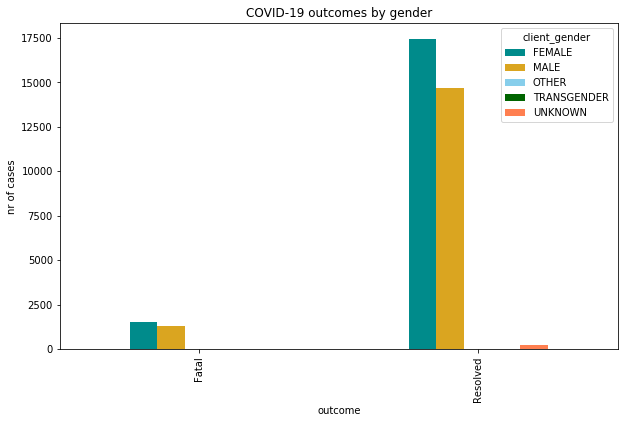

In [43]:
# Plotting the data
pd.crosstab(df.##utcome1, df.client_gender).plot(kind="bar", figsize=(10,6), color=["darkcyan", "goldenrod", "skyblue", "darkgreen", "coral"])

plt.title("COVID-19 outcomes by gender")
plt.xlabel("outcome")
plt.ylabel("nr of cases");

### Age for COVID-19 outcomes

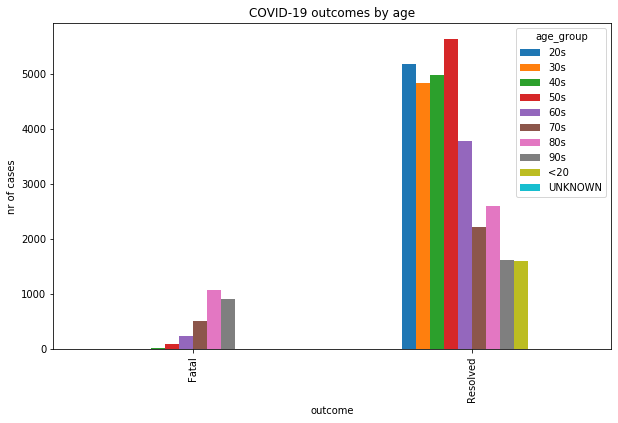

In [62]:
pd.crosstab(df.outcome1, df.age_group).plot(kind="bar", figsize=(10,6))

plt.title("COVID-19 outcomes by age")
plt.xlabel("outcome")
plt.ylabel("nr of cases");

### Correlation Analysis of Independent Data

In [66]:
corr_matrix = df.corr()
corr_matrix

,id,row_id,reporting_phu_latitude,reporting_phu_longitude
id,1.000000,0.998763,-0.008555,0.036464
row_id,0.998763,1.000000,-0.009167,0.037896
reporting_phu_latitude,-0.008555,-0.009167,1.000000,0.463740
reporting_phu_longitude,0.036464,0.037896,0.463740,1.000000


## Modeling

In [127]:
df.head()


,accurate_episode_date,age_group,client_gender,case_acquisitionInfo,outcome1,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,test_reported_date
0,2020-03-28,20s,FEMALE,Travel,Resolved,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670,2020-04-03,2020-04-03
1,2020-03-13,30s,MALE,Travel,Resolved,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912,2020-03-26,2020-03-26
2,2020-04-12,20s,FEMALE,No Epi-link,Resolved,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016,2020-05-20,2020-05-20
3,2020-04-12,30s,FEMALE,CC,Resolved,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913,2020-04-15,2020-04-15
4,2020-03-23,30s,MALE,CC,Resolved,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298,2020-04-01,2020-04-01


Split data into target variable ("outcome1") and predictor variables. 

### Transform the features

In [198]:
df.dtypes

id                             int64
row_id                         int64
accurate_episode_date         object
age_group                     object
client_gender                 object
case_acquisitionInfo          object
outcome1                      object
outbreak_related              object
reporting_phu                 object
reporting_phu_address         object
reporting_phu_city            object
reporting_phu_postal_code     object
reporting_phu_website         object
reporting_phu_latitude       float64
reporting_phu_longitude      float64
case_reported_date            object
specimen_reported_date        object
test_reported_date            object
dtype: object

In [202]:
df.isna().sum()

id                               0
row_id                           0
accurate_episode_date            0
age_group                        0
client_gender                    0
case_acquisitionInfo             0
outcome1                         0
outbreak_related             20611
reporting_phu                    0
reporting_phu_address            0
reporting_phu_city               0
reporting_phu_postal_code        0
reporting_phu_website            0
reporting_phu_latitude           0
reporting_phu_longitude          0
case_reported_date               0
specimen_reported_date         329
test_reported_date             447
dtype: int64

We convert dates into days from the date of first reported case.

In [5]:
from datetime import date
from datetime import datetime

d0 = pd.to_datetime('2020-01-01')

df["accurate_episode_date"] = pd.to_datetime(df["accurate_episode_date"])
df["case_reported_date"] = pd.to_datetime(df["case_reported_date"])
df["test_reported_date"] = pd.to_datetime(df["test_reported_date"])

df["accurate_episode_date"] = (df["accurate_episode_date"] - d0).dt.days
df["case_reported_date"] = (df["case_reported_date"] - d0).dt.days
df["test_reported_date"] = (df["test_reported_date"] - d0).dt.days

Since there is only one missing value for accurate_episode_date, we exclude that data point.

In [6]:
df.dropna(subset = ["accurate_episode_date"], inplace = True)

In [7]:
df.drop(columns=["id", "row_id", "case_acquisitionInfo", "reporting_phu_address", "reporting_phu_website", "specimen_reported_date"], axis =1, inplace =True)

In [7]:
df.head()

,accurate_episode_date,age_group,client_gender,outcome1,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,test_reported_date
0,87.0,20s,FEMALE,Resolved,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670,93,93.0
1,72.0,30s,MALE,Resolved,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912,85,85.0
2,102.0,20s,FEMALE,Resolved,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016,140,140.0
3,102.0,30s,FEMALE,Resolved,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913,105,105.0
4,82.0,30s,MALE,Resolved,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298,91,91.0


### Train test split

In [8]:
X = df.drop("outcome1", axis = 1)
y = df["outcome1"]

In [9]:
X.head()

,accurate_episode_date,age_group,client_gender,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,test_reported_date
0,87.0,20s,FEMALE,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670,93,93.0
1,72.0,30s,MALE,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912,85,85.0
2,102.0,20s,FEMALE,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016,140,140.0
3,102.0,30s,FEMALE,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913,105,105.0
4,82.0,30s,MALE,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298,91,91.0


In [10]:
y

0        Resolved
1        Resolved
2        Resolved
3        Resolved
4        Resolved
           ...   
37942    Resolved
37943    Resolved
37944    Resolved
37945    Resolved
37946    Resolved
Name: outcome1, Length: 37945, dtype: object

In [11]:
np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size = 0.2)

In [12]:
print(X_train.shape, 
     X_test.shape, 
     y_train.shape, 
     y_test.shape, 
     sep="\n")

(30356, 11)
(7589, 11)
(30356,)
(7589,)


In [13]:
type(df.reporting_phu_postal_code[1])

str

In [228]:
# custom transformer that assigns numbers to the age_groups
from sklearn.base import BaseEstimator, TransformerMixin
class CustomNumericalTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        print("init called")
        
    def fit(self, X, y = None):
        print("fit called")
        return self
    
    
    def transform(self, X, y=None):
        transformed_X = X.copy()
        
        for i in X.index.values.tolist(): 
            if X.loc[i].values == "<20":
                transformed_X[i] = 10
            else:    
                transformed_X[i] = float(str(X.loc[i].values)[-5:-3])
        #print(transformed_X[i]) 
        i += 1
        print(transformed_X)
        return transformed_X

In [55]:
# custom transformer that assigns numbers to the age_groups
from sklearn.base import BaseEstimator, TransformerMixin
class CustomNumericalTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        print("init called")
        
    def fit(self, X, y = None):
        print("fit called")
        return self
    
    
    def transform(self, X, y=None):
        print("transform called")
        transformed_X = pd.DataFrame(X.copy())
        print(type(transformed_X))
        print(transformed_X.shape)
        transformed_X = transformed_X.replace({'80s':80, '20s':20, '<20':10, '60s':60, '50s':50, '70s':70, '30s':30, '40s':40, '90s':90})

        print(transformed_X)
        return transformed_X



In [56]:
# Define different features and transformer pipeline
categorical_features = ["client_gender", "outbreak_related", "reporting_phu", "reporting_phu_city", "reporting_phu_postal_code"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

numeric_features = ["age_group"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(missing_values="UNKNOWN",strategy="most_frequent")),
    ("num_transformer", CustomNumericalTransformer() )
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)])

model = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", RandomForestClassifier())])

model.fit(X_train, y_train)



init called
init called
fit called
transform called
<class 'pandas.core.frame.DataFrame'>
(30356, 1)
        0
0      70
1      90
2      50
3      20
4      90
...    ..
30351  20
30352  80
30353  50
30354  20
30355  50

[30356 rows x 1 columns]


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                      

In [57]:
model.score(X_test, y_test)

transform called
<class 'pandas.core.frame.DataFrame'>
(7589, 1)
       0
0     40
1     70
2     60
3     20
4     10
...   ..
7584  50
7585  60
7586  40
7587  40
7588  80

[7589 rows x 1 columns]


0.8538674397153775

### Fit models

In [ ]:
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

In [219]:
df.age_group.value_counts()

50s        5720
20s        5171
40s        5002
30s        4832
60s        4019
80s        3678
70s        2730
90s        2534
<20        1593
UNKNOWN       7
Name: age_group, dtype: int64